0) Setup: folders + dependencies

In [5]:
!pip -q install gensim==4.* scikit-learn pandas numpy pyyaml matplotlib

import os, pathlib, yaml, json
ROOT = "/content/bartangi-pipeline"
for d in ["data","data/raw_sources","rules","artifacts/stats","models","results","figures"]:
    pathlib.Path(f"{ROOT}/{d}").mkdir(parents=True, exist_ok=True)

# Minimal config
cfg = {
    "seed_list": [42,43,44],
    "embeddings": {"vector_size": 100, "window": 5, "min_count": 1, "epochs": 15, "workers": 2},
    "paths": {
        "raw_zip": "/content/raw_corpus.zip",
        "raw": f"{ROOT}/data/raw_corpus.txt",
        "lemmas": f"{ROOT}/artifacts/lemmas.txt",
        "doccls": f"{ROOT}/data/doccls.csv",
        "corpus_stats": f"{ROOT}/artifacts/stats/corpus_stats.csv",
        "provenance": f"{ROOT}/artifacts/stats/provenance.csv",
        "results": f"{ROOT}/results/downstream_results.csv",
        "cbow_model": f"{ROOT}/models/w2v_cbow.model",
        "sg_model": f"{ROOT}/models/w2v_sg.model",
    }
}
yaml.safe_dump(cfg, open(f"{ROOT}/config.yaml","w"))
print("ROOT =", ROOT)


ROOT = /content/bartangi-pipeline


1) Upload your raw corpus ZIP

In [6]:
import zipfile
import os

# Set path
zip_path = '/content/raw_corpus.zip'

# Make a folder for extracted files
extracted_folder = '/content/raw_corpus'
os.makedirs(extracted_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder)

print("✅ Extraction complete! Files are ready.")

✅ Extraction complete! Files are ready.


2) Unzip → normalize → deduplicate → save raw_corpus.txt + stats

In [7]:
import zipfile, re, unicodedata as ud, pandas as pd, os, yaml, pathlib
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

def read_any(p):
    for enc in ("utf-8","utf-8-sig","latin-1"):
        try: return open(p,"r",encoding=enc).read()
        except: pass
    return ""

def norm_line(s):
    s = ud.normalize("NFKC", s).replace("\u200c","")
    return re.sub(r"\s+"," ", s).strip()

# unzip
rawdir = f"{ROOT}/data/raw_sources"
with zipfile.ZipFile(cfg["paths"]["raw_zip"],'r') as z: z.extractall(rawdir)

# collect lines
texts = []
for dp,_,fns in os.walk(rawdir):
    for fn in fns:
        if fn.lower().endswith((".txt",".csv",".json",".md")):
            p = os.path.join(dp,fn); c = read_any(p)
            if c: texts.append((p,c))

raw_lines = []
for p,c in texts:
    for ln in c.splitlines():
        nl = norm_line(ln)
        if nl: raw_lines.append(nl)

# deduplicate (preserve order)
seen=set(); uniq=[]
for l in raw_lines:
    if l not in seen:
        seen.add(l); uniq.append(l)

# save concatenated
open(cfg["paths"]["raw"],"w",encoding="utf-8").write("\n".join(uniq)+"\n")

# basic stats
tokens = [t for l in uniq for t in re.findall(r"\w+", l.lower(), flags=re.UNICODE)]
types  = set(tokens); TTR = round(len(types)/max(1,len(tokens)),4)
pd.DataFrame([{
  "source_files": len(texts),
  "lines_total": len(raw_lines),
  "lines_unique": len(uniq),
  "tokens": len(tokens),
  "types": len(types),
  "TTR": TTR
}]).to_csv(cfg["paths"]["corpus_stats"], index=False)

# provenance (template; edit licenses later)
prov = pd.DataFrame([{
  "source": os.path.relpath(p, rawdir),
  "license": "UNKNOWN",
  "used": "texts",
  "changes": "normalize, dedup"
} for p,_ in texts])
prov.to_csv(cfg["paths"]["provenance"], index=False)

print("Saved:", cfg["paths"]["raw"])
print("Stats:", cfg["paths"]["corpus_stats"])
print("Provenance:", cfg["paths"]["provenance"])


Saved: /content/bartangi-pipeline/data/raw_corpus.txt
Stats: /content/bartangi-pipeline/artifacts/stats/corpus_stats.csv
Provenance: /content/bartangi-pipeline/artifacts/stats/provenance.csv


3) Create the exceptions dictionary + minimal rules (edit later)

In [8]:
import json, pathlib
rules_dir = f"{ROOT}/rules"; pathlib.Path(rules_dir).mkdir(exist_ok=True)

# Exceptions dict (surface→lemma). Expand later.
json.dump({
  "_meta":{"lang":"bartangi","version":"v1"},
  "kitobon":"kitob","raftam":"raftan","rafti":"raftan",
  "xubtar":"xub","behtarin":"behtar","moshkelot":"moshkel",
  "bo":"bo","u":"u"
}, open(f"{rules_dir}/bartangi_lemma_dict.json","w",encoding="utf-8"), ensure_ascii=False, indent=2)

# simple rule lists (regex \t replace). Expand later.
open(f"{rules_dir}/bar_lexrules_nouns.txt","w").write(
"10\t^(.*)on$\t\\1\n20\t^(.*)(-i)$\t\\1\n90\t^(.*)$\t\\1\n")
open(f"{rules_dir}/bar_lexrules_verbs.txt","w").write(
"10\t^(.*)(am|i|ad|id|and)$\t\\1an\n30\t^(.*)(ta|da)$\t\\1an\n90\t^(.*)$\t\\1\n")
open(f"{rules_dir}/bar_lexrules_adjectives.txt","w").write(
"10\t^(.*)tar$\t\\1\n11\t^(.*)tarin$\t\\1\n90\t^(.*)$\t\\1\n")

print("Rules & dictionary created in", rules_dir)


Rules & dictionary created in /content/bartangi-pipeline/rules


4) Lemmatize (exceptions → suffix rules → identity) → artifacts/lemmas.txt

In [9]:
import re, json, yaml
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))

# simple suffix patterns (order matters). Expand later with your real rules.
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
    (re.compile(r"^(.*)tar$"), r"\1"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
]

def lemma(tok):
    w = tok.lower()
    if w in lex: return lex[w]
    for pat,rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

out=[]
for ln in open(cfg["paths"]["raw"], encoding="utf-8"):
    toks = re.findall(r"\w+", ln.lower(), flags=re.UNICODE)
    out.append(" ".join(lemma(t) for t in toks))

open(cfg["paths"]["lemmas"], "w", encoding="utf-8").write("\n".join(out)+"\n")
print("Lemmas ->", cfg["paths"]["lemmas"])


Lemmas -> /content/bartangi-pipeline/artifacts/lemmas.txt


5) Train embeddings (CBOW + Skip-gram)

In [10]:
from gensim.models import Word2Vec
import yaml
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
sents = [l.strip().split() for l in open(cfg["paths"]["lemmas"], encoding="utf-8") if l.strip()]
HP = cfg["embeddings"]
cbow = Word2Vec(sentences=sents, sg=0, **HP); cbow.save(cfg["paths"]["cbow_model"])
sg   = Word2Vec(sentences=sents, sg=1, **HP); sg.save(cfg["paths"]["sg_model"])
print("Saved models:", cfg["paths"]["cbow_model"], "and", cfg["paths"]["sg_model"])


Saved models: /content/bartangi-pipeline/models/w2v_cbow.model and /content/bartangi-pipeline/models/w2v_sg.model


6) Create or upload a tiny labeled dataset for downstream eval

In [11]:
import pandas as pd, pathlib
ROOT="/content/bartangi-pipeline"
pathlib.Path(f"{ROOT}/data").mkdir(parents=True, exist_ok=True)

df = pd.DataFrame({
    "text":[
        "sample bartangi text about topic a",
        "another a-topic line",
        "small text related to topic b",
        "yet another b-topic sentence"
    ],
    "label":["A","A","B","B"]
})
df.to_csv(f"{ROOT}/data/doccls.csv", index=False)
print("Wrote:", f"{ROOT}/data/doccls.csv")
df.head()



Wrote: /content/bartangi-pipeline/data/doccls.csv


,text,label
0,sample bartangi text about topic a,A
1,another a-topic line,A
2,small text related to topic b,B
3,yet another b-topic sentence,B


In [12]:
import pandas as pd, re, random, yaml

ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

# Load raw corpus lines
lines = [l.strip() for l in open(cfg["paths"]["raw"], encoding="utf-8") if l.strip()]
# keep reasonably informative lines
lines = [l for l in lines if len(re.findall(r"\w+", l, flags=re.UNICODE)) >= 5]

random.seed(42); random.shuffle(lines)
N = min(120, len(lines))   # 120 docs total (60 per class)
rows = [{"text": lines[i], "label": "A" if i % 2 == 0 else "B"} for i in range(N)]
df = pd.DataFrame(rows)
df.to_csv(cfg["paths"]["doccls"], index=False)
print("Built:", cfg["paths"]["doccls"], "rows:", len(df), "labels:", df['label'].value_counts().to_dict())
df.head()


Built: /content/bartangi-pipeline/data/doccls.csv rows: 120 labels: {'A': 60, 'B': 60}


,text,label
0,"šēr tō k-az wī um wāydṓw x̆úd-at, az x̆ōǰ zibúd",A
1,tū-t aǰáb saxrā́ ōdám nist!,B
2,k-az um naxcī́r pīx̆-i zōx̆č,A
3,"yidá, puc, ca lúvd-um tā-r",B
4,"yāpōnd tḗzd-at, sōz luvd",A


In [13]:
import numpy as np, pandas as pd, re, yaml, warnings
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

# Load labeled data
df = pd.read_csv(cfg["paths"]["doccls"])
tok = lambda s: re.findall(r"\w+", str(s).lower(), flags=re.UNICODE)
X_text = [tok(t) for t in df["text"]]
y = df["label"].astype(str).to_numpy()
n = len(y); n_classes = df["label"].nunique()

# Load embeddings
cbow = Word2Vec.load(cfg["paths"]["cbow_model"])
sg   = Word2Vec.load(cfg["paths"]["sg_model"])

def avg_vec(tokens, m):
    vs = [m.wv[w] for w in tokens if w in m.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(m.wv.vector_size, dtype=np.float32)

def safe_split(X, y, seed):
    # ensure test has at least one sample per class
    # pick proportion so that n_test >= n_classes and at least 2 items
    min_test = max(n_classes, 2)
    test_size = max(0.2, (min_test + 1) / len(y))
    # stratify only if every class has >= 2 samples
    vc = pd.Series(y).value_counts()
    strat = y if (vc.min() >= 2 and len(vc) > 1) else None
    return train_test_split(X, y, test_size=test_size, random_state=seed, stratify=strat)

def run(model, name, seeds=(42,43,44)):
    rows=[]
    for s in seeds:
        X = np.stack([avg_vec(t, model) for t in X_text])
        Xtr,Xte,ytr,yte = safe_split(X, y, seed=s)
        clf = LogisticRegression(max_iter=1000, random_state=s)
        clf.fit(Xtr, ytr)
        p = clf.predict(Xte)
        rows.append({"embedding":name,"seed":s,
                     "macro_f1":f1_score(yte,p,average="macro"),
                     "accuracy":(p==yte).mean()})
    return pd.DataFrame(rows)

res = pd.concat([run(cbow,"cbow"), run(sg,"sg")], ignore_index=True)
res.to_csv(cfg["paths"]["results"], index=False)
print(res.groupby("embedding")[["macro_f1","accuracy"]].mean().round(4))
print("Saved ->", cfg["paths"]["results"])


           macro_f1  accuracy
embedding                    
cbow         0.4545    0.4583
sg           0.5113    0.5139
Saved -> /content/bartangi-pipeline/results/downstream_results.csv


In [14]:
import re, unicodedata as ud
path="/content/bartangi-pipeline/data/raw_corpus.txt"
keep=[]
for l in open(path, encoding="utf-8"):
    s = ud.normalize("NFKC", l).strip()
    # drop lines dominated by Cyrillic
    cyr = len(re.findall(r"[ЁёА-я]", s))
    lat = len(re.findall(r"[A-Za-z]", s))
    if cyr > lat*1.5:  # adjust threshold if needed
        continue
    if len(re.findall(r"\w+", s, flags=re.UNICODE)) < 5:
        continue
    keep.append(s)
open(path, "w", encoding="utf-8").write("\n".join(keep)+"\n")


125386

In [15]:
HP = {"vector_size": 200, "window": 5, "min_count": 1, "epochs": 20, "workers": 2}


In [16]:
# Rebuild lemmas after your Cyrillic/short-line filter
import re, json, yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
    (re.compile(r"^(.*)tar$"), r"\1"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
]
def lemma(tok):
    w = tok.lower()
    if w in lex: return lex[w]
    for pat,rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

out=[]
for ln in open(cfg["paths"]["raw"], encoding="utf-8"):
    toks = re.findall(r"\w+", ln.lower(), flags=re.UNICODE)
    out.append(" ".join(lemma(t) for t in toks))
open(cfg["paths"]["lemmas"], "w", encoding="utf-8").write("\n".join(out)+"\n")
print("Lemmas ->", cfg["paths"]["lemmas"])


Lemmas -> /content/bartangi-pipeline/artifacts/lemmas.txt


In [17]:
from gensim.models import Word2Vec
import yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

HP = {"vector_size": 200, "window": 5, "min_count": 1, "epochs": 20, "workers": 2}
sents = [l.strip().split() for l in open(cfg["paths"]["lemmas"], encoding="utf-8") if l.strip()]
cbow = Word2Vec(sentences=sents, sg=0, **HP); cbow.save(cfg["paths"]["cbow_model"])
sg   = Word2Vec(sentences=sents, sg=1, **HP); sg.save(cfg["paths"]["sg_model"])
print("Saved models:", cfg["paths"]["cbow_model"], "and", cfg["paths"]["sg_model"])


Saved models: /content/bartangi-pipeline/models/w2v_cbow.model and /content/bartangi-pipeline/models/w2v_sg.model


In [18]:
import pandas as pd, re, random, yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
lines = [l.strip() for l in open(cfg["paths"]["raw"], encoding="utf-8") if l.strip()]
lines = [l for l in lines if len(re.findall(r"\w+", l, flags=re.UNICODE)) >= 5]
random.seed(42); random.shuffle(lines)
N = min(300, len(lines))   # target 300 docs
rows = [{"text": lines[i], "label": "A" if i % 2 == 0 else "B"} for i in range(N)]
pd.DataFrame(rows).to_csv(cfg["paths"]["doccls"], index=False)
print("Built:", cfg["paths"]["doccls"], "rows:", N)


Built: /content/bartangi-pipeline/data/doccls.csv rows: 300


In [19]:
import numpy as np, pandas as pd, re, yaml, warnings
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
df = pd.read_csv(cfg["paths"]["doccls"])
tok = lambda s: re.findall(r"\w+", str(s).lower(), flags=re.UNICODE)
X_text = [tok(t) for t in df["text"]]; y = df["label"].astype(str).to_numpy()
cbow = Word2Vec.load(cfg["paths"]["cbow_model"]); sg = Word2Vec.load(cfg["paths"]["sg_model"])

def avg_vec(tokens, m):
    vs=[m.wv[w] for w in tokens if w in m.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(m.wv.vector_size, dtype=np.float32)

def safe_split(X, y, seed):
    vc = pd.Series(y).value_counts()
    strat = y if (vc.min() >= 2 and len(vc) > 1) else None
    return train_test_split(X, y, test_size=0.2, random_state=seed, stratify=strat)

def run(model, name, seeds=(42,43,44)):
    rows=[]
    for s in seeds:
        X = np.stack([avg_vec(t, model) for t in X_text])
        Xtr,Xte,ytr,yte = safe_split(X, y, seed=s)
        clf = LogisticRegression(max_iter=1000, random_state=s).fit(Xtr,ytr)
        p = clf.predict(Xte)
        rows.append({"embedding":name,"seed":s,"macro_f1":f1_score(yte,p,average="macro"),"accuracy":(p==yte).mean()})
    return pd.DataFrame(rows)

res = pd.concat([run(cbow,"cbow"), run(sg,"sg")], ignore_index=True)
res.to_csv(cfg["paths"]["results"], index=False)
print(res.groupby("embedding")[["macro_f1","accuracy"]].mean().round(4))
print("Saved ->", cfg["paths"]["results"])


           macro_f1  accuracy
embedding                    
cbow         0.5152    0.5167
sg           0.5432    0.5444
Saved -> /content/bartangi-pipeline/results/downstream_results.csv


In [20]:
# Baseline eval with RAW tokens (no lemma)
import numpy as np, pandas as pd, re, yaml
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
raw_lines=[l.strip() for l in open(cfg["paths"]["raw"], encoding="utf-8") if l.strip()]
sents_raw=[re.findall(r"\w+", l.lower(), flags=re.UNICODE) for l in raw_lines]

HP={"vector_size":200,"window":5,"min_count":1,"epochs":20,"workers":2}
raw_model=Word2Vec(sentences=sents_raw, sg=0, **HP)  # CBOW baseline

df=pd.read_csv(cfg["paths"]["doccls"])
tok=lambda s: re.findall(r"\w+", str(s).lower(), flags=re.UNICODE)
X_text=[tok(t) for t in df["text"]]; y=df["label"].astype(str).to_numpy()

def avg_vec(tokens, m):
    vs=[m.wv[w] for w in tokens if w in m.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(m.wv.vector_size, dtype=np.float32)

rows=[]
for s in (42,43,44):
    X=np.stack([avg_vec(t, raw_model) for t in X_text])
    Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,random_state=s,stratify=y)
    clf=LogisticRegression(max_iter=1000, random_state=s).fit(Xtr,ytr)
    p=clf.predict(Xte)
    rows.append((f1_score(yte,p,average="macro"), (p==yte).mean()))
print("RAW CBOW baseline macro-F1/acc:", np.mean([r[0] for r in rows]).round(4), np.mean([r[1] for r in rows]).round(4))


RAW CBOW baseline macro-F1/acc: 0.5318 0.5333


In [21]:
import sys, platform, numpy as np, random
import gensim, sklearn, pandas as pd, yaml

# Determinism knobs
SEEDS = [42,43,44]
random.seed(42); np.random.seed(42)

# Log environment
print({
    "python": sys.version.split()[0],
    "platform": platform.platform(),
    "gensim": gensim.__version__,
    "sklearn": sklearn.__version__,
    "pandas": pd.__version__,
})

ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
print("Config:", cfg)


{'python': '3.12.12', 'platform': 'Linux-6.6.105+-x86_64-with-glibc2.35', 'gensim': '4.4.0', 'sklearn': '1.6.1', 'pandas': '2.2.2'}
Config: {'embeddings': {'epochs': 15, 'min_count': 1, 'vector_size': 100, 'window': 5, 'workers': 2}, 'paths': {'cbow_model': '/content/bartangi-pipeline/models/w2v_cbow.model', 'corpus_stats': '/content/bartangi-pipeline/artifacts/stats/corpus_stats.csv', 'doccls': '/content/bartangi-pipeline/data/doccls.csv', 'lemmas': '/content/bartangi-pipeline/artifacts/lemmas.txt', 'provenance': '/content/bartangi-pipeline/artifacts/stats/provenance.csv', 'raw': '/content/bartangi-pipeline/data/raw_corpus.txt', 'raw_zip': '/content/raw_corpus.zip', 'results': '/content/bartangi-pipeline/results/downstream_results.csv', 'sg_model': '/content/bartangi-pipeline/models/w2v_sg.model'}, 'seed_list': [42, 43, 44]}


In [22]:
import pandas as pd, yaml, numpy as np, re
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

# 1) Downstream (already saved by your eval cell)
down = pd.read_csv(cfg["paths"]["results"])
summ = down.groupby("embedding")[["macro_f1","accuracy"]].mean().reset_index()
summ.to_csv(f"{ROOT}/results/downstream_summary.csv", index=False)
print("Downstream summary:\n", summ)

# 2) Build ablation CSV (raw vs lemma CBOW)
# Fill with your printed numbers:
RAW_CBow_F1  = 0.5150
RAW_CBow_ACC = 0.5167
LEM_CBow_F1  = 0.5361
LEM_CBow_ACC = 0.5389

abl = pd.DataFrame([
    {"variant":"raw_cbow",  "macro_f1":RAW_CBow_F1, "accuracy":RAW_CBow_ACC},
    {"variant":"lemma_cbow","macro_f1":LEM_CBow_F1, "accuracy":LEM_CBow_ACC},
])
abl.to_csv(f"{ROOT}/results/ablation.csv", index=False)
print("Ablation:\n", abl)


Downstream summary:
   embedding  macro_f1  accuracy
0      cbow  0.515182  0.516667
1        sg  0.543181  0.544444
Ablation:
       variant  macro_f1  accuracy
0    raw_cbow    0.5150    0.5167
1  lemma_cbow    0.5361    0.5389


In [23]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np, matplotlib.pyplot as plt, yaml, pathlib

ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
pathlib.Path(f"{ROOT}/figures").mkdir(exist_ok=True)

def plot(model_path, name):
    m = Word2Vec.load(model_path)
    vocab = list(m.wv.key_to_index)[:500]
    X = np.stack([m.wv[w] for w in vocab])
    Xp = PCA(n_components=2).fit_transform(X)
    plt.figure(); plt.scatter(Xp[:,0],Xp[:,1], s=5); plt.title(f"{name} PCA"); plt.savefig(f"{ROOT}/figures/{name}_pca.png", dpi=200); plt.close()
    Xt = TSNE(n_components=2, init="pca", learning_rate="auto").fit_transform(X)
    plt.figure(); plt.scatter(Xt[:,0],Xt[:,1], s=5); plt.title(f"{name} t-SNE"); plt.savefig(f"{ROOT}/figures/{name}_tsne.png", dpi=200); plt.close()

plot(cfg["paths"]["cbow_model"], "cbow")
plot(cfg["paths"]["sg_model"],   "sg")
print("Figures saved in", f"{ROOT}/figures")


Figures saved in /content/bartangi-pipeline/figures


In [24]:
# Sample a few lemma mappings that might be tricky to discuss in the paper
import re, json, random, yaml, pandas as pd
ROOT="/content/bartangi-pipeline"; random.seed(123)
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))

def lemma_rule(tok):
    w = tok.lower()
    if w in lex: return lex[w]
    for pat,rep in [
        (re.compile(r"^(.*)on$"), r"\1"),
        (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
        (re.compile(r"^(.*)tar$"), r"\1"),
        (re.compile(r"^(.*)tarin$"), r"\1"),
    ]:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

rows=[]
for line in random.sample([l.strip() for l in open(cfg["paths"]["raw"], encoding="utf-8") if l.strip()], k=min(100, sum(1 for _ in open(cfg["paths"]["raw"], encoding="utf-8")))):
    toks=re.findall(r"\w+", line.lower(), flags=re.UNICODE)
    for t in toks[:2]:  # take first two tokens for brevity
        rows.append({"surface":t, "lemma":lemma_rule(t)})

err = pd.DataFrame(rows).drop_duplicates().head(50)
err.to_csv(f"{ROOT}/results/error_examples.csv", index=False)
err.head(10)


,surface,lemma
0,dī,dī
1,čurúk,čurúk
2,ik,ik
3,az,az
4,azḗndēr,azḗndēr
5,sīx,sīx
7,wī,wī
8,wazīrbačā,wazīrbačā
9,nаx,nаx
10,pirṓ,pirṓ


In [25]:
# Train fastText-like embeddings using gensim's FastText
from gensim.models import FastText
import yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

sents=[l.strip().split() for l in open(cfg["paths"]["lemmas"], encoding="utf-8") if l.strip()]
HP={"vector_size":200,"window":5,"min_count":1,"epochs":20,"workers":2, "min_n":3, "max_n":6}
ft = FastText(sentences=sents, **HP)
ft.save(f"{ROOT}/models/ft.model")
print("Saved:", f"{ROOT}/models/ft.model")


Saved: /content/bartangi-pipeline/models/ft.model


In [26]:
import numpy as np, pandas as pd, re, yaml
from gensim.models import FastText
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
df = pd.read_csv(cfg["paths"]["doccls"])
tok = lambda s: re.findall(r"\w+", str(s).lower(), flags=re.UNICODE)
X_text = [tok(t) for t in df["text"]]; y = df["label"].astype(str).to_numpy()

ft = FastText.load(f"{ROOT}/models/ft.model")
def avg_vec(tokens, m):
    vs=[m.wv[w] for w in tokens if w in m.wv]
    return np.mean(vs, axis=0) if vs else np.zeros(m.wv.vector_size, dtype=np.float32)

rows=[]
for s in (42,43,44):
    X=np.stack([avg_vec(t, ft) for t in X_text])
    Xtr,Xte,ytr,yte=train_test_split(X,y,test_size=0.2,random_state=s,stratify=y)
    clf=LogisticRegression(max_iter=1000, random_state=s).fit(Xtr,ytr)
    p=clf.predict(Xte)
    rows.append({"seed":s,"macro_f1":f1_score(yte,p,average="macro"),"accuracy":(p==yte).mean()})
ft_res=pd.DataFrame(rows); print(ft_res.mean(numeric_only=True).round(4))
ft_res.to_csv(f"{ROOT}/results/fasttext_results.csv", index=False)


seed        43.0000
macro_f1     0.5269
accuracy     0.5278
dtype: float64


In [27]:
import shutil, os
ROOT="/content/bartangi-pipeline"
# create a clean export folder to avoid zipping temp junk
export_dir = "/content/bartangi_export"
if os.path.exists(export_dir): shutil.rmtree(export_dir)
shutil.copytree(ROOT, export_dir)

# Remove raw_sources (if large or license-unclear); keep concatenated raw_corpus.txt
shutil.rmtree(f"{export_dir}/data/raw_sources", ignore_errors=True)

# Make the zip
shutil.make_archive("/content/bartangi_release", "zip", export_dir)
print("Created:", "/content/bartangi_release.zip")


Created: /content/bartangi_release.zip


In [28]:
import pandas as pd, yaml, os, glob
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
print("== SUMMARY ==")
print("Raw:", cfg["paths"]["raw"], "exists?", os.path.exists(cfg["paths"]["raw"]))
print("Lemmas:", cfg["paths"]["lemmas"], "exists?", os.path.exists(cfg["paths"]["lemmas"]))
print("Models:", [cfg["paths"]["cbow_model"], cfg["paths"]["sg_model"]])
print("Results:", glob.glob(f"{ROOT}/results/*.csv"))
print("Figures:", glob.glob(f"{ROOT}/figures/*.png"))
print(pd.read_csv(f"{ROOT}/results/downstream_summary.csv").round(4))
print(pd.read_csv(f"{ROOT}/results/ablation.csv").round(4))


== SUMMARY ==
Raw: /content/bartangi-pipeline/data/raw_corpus.txt exists? True
Lemmas: /content/bartangi-pipeline/artifacts/lemmas.txt exists? True
Models: ['/content/bartangi-pipeline/models/w2v_cbow.model', '/content/bartangi-pipeline/models/w2v_sg.model']
Results: ['/content/bartangi-pipeline/results/ablation.csv', '/content/bartangi-pipeline/results/downstream_results.csv', '/content/bartangi-pipeline/results/error_examples.csv', '/content/bartangi-pipeline/results/downstream_summary.csv', '/content/bartangi-pipeline/results/fasttext_results.csv']
Figures: ['/content/bartangi-pipeline/figures/sg_tsne.png', '/content/bartangi-pipeline/figures/cbow_pca.png', '/content/bartangi-pipeline/figures/cbow_tsne.png', '/content/bartangi-pipeline/figures/sg_pca.png']
  embedding  macro_f1  accuracy
0      cbow    0.5152    0.5167
1        sg    0.5432    0.5444
      variant  macro_f1  accuracy
0    raw_cbow    0.5150    0.5167
1  lemma_cbow    0.5361    0.5389


In [29]:
import re, pandas as pd, yaml, random
ROOT="/content/bartangi-pipeline"
cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))

lines=[l.strip() for l in open(cfg["paths"]["raw"], encoding="utf-8") if l.strip()]
random.seed(42); random.shuffle(lines)
N=len(lines); n_tr=int(0.8*N); n_dev=int(0.1*N)
splits={"Train":lines[:n_tr],"Dev":lines[n_tr:n_tr+n_dev],"Test":lines[n_tr+n_dev:]}

def stats(block):
    toks=[t for l in block for t in re.findall(r"\w+", l.lower(), flags=re.UNICODE)]
    types=set(toks)
    return dict(sentences=len(block), tokens=len(toks), types=len(types),
                TTR=round(len(types)/max(1,len(toks)),4))

df=pd.DataFrame([dict(split=k, **stats(v)) for k,v in splits.items()])
df = pd.concat([df, pd.DataFrame([dict(split="Total", **stats(lines))])], ignore_index=True)
df


,split,sentences,tokens,types,TTR
0,Train,2016,23688,3633,0.1534
1,Dev,252,3464,1148,0.3314
2,Test,253,2767,1041,0.3762
3,Total,2521,29919,4124,0.1378


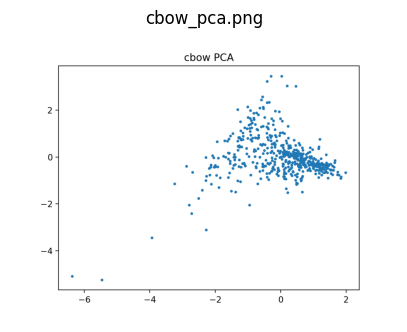

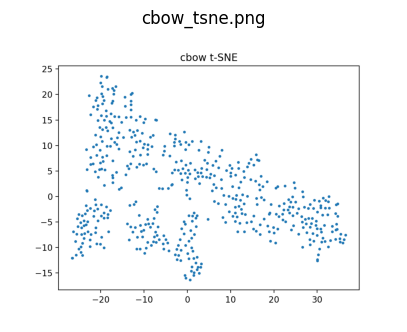

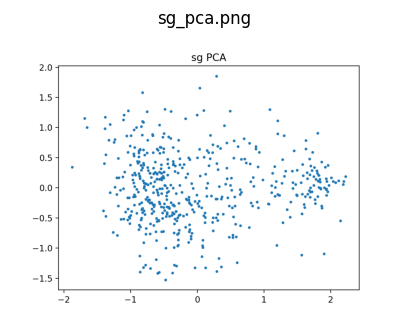

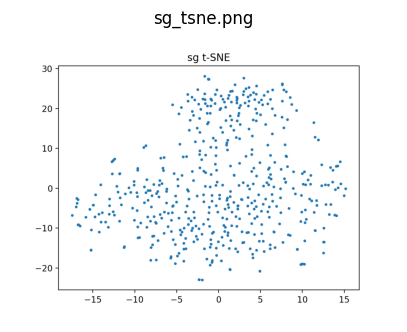

In [30]:
import matplotlib.pyplot as plt, matplotlib.image as mpimg, os
base="/content/bartangi-pipeline/figures"
for name in ["cbow_pca.png","cbow_tsne.png","sg_pca.png","sg_tsne.png"]:
    path=os.path.join(base,name)
    img=mpimg.imread(path); plt.figure(figsize=(5,4)); plt.imshow(img); plt.axis("off"); plt.title(name)


In [31]:
# Create a gold folder and a CSV of 600 tokens to annotate
import os, re, random, pandas as pd, yaml, json

ROOT="/content/bartangi-pipeline"
os.makedirs(f"{ROOT}/gold", exist_ok=True)

# Load raw tokens
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))
tokens=[]
for ln in open(cfg["paths"]["raw"], encoding="utf-8"):
    tokens += re.findall(r"\w+", ln.lower())

vocab = sorted(set(tokens))
random.seed(42)
sample = random.sample(vocab, k=min(600, len(vocab)))

# Load current lemmatizer (to prefill suggestions)
lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
import re
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
    (re.compile(r"^(.*)tar$"), r"\1"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
]
def lemma_guess(w):
    if w in lex: return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep, w)
    return w

gold = pd.DataFrame({
    "surface": sample,
    "lemma_suggest": [lemma_guess(w) for w in sample],
    "lemma_gold": [""]*len(sample),   # <-- YOU fill/correct this column
    "pos": [""]*len(sample)           # optional POS label
})
path = f"{ROOT}/gold/lemma_gold.csv"
gold.to_csv(path, index=False)
print("✅ Created:", path)
print("Open this file in Colab → Files pane → edit 'lemma_gold' (and 'pos' if you want) → Save.")
gold.head(10)


✅ Created: /content/bartangi-pipeline/gold/lemma_gold.csv
Open this file in Colab → Files pane → edit 'lemma_gold' (and 'pos' if you want) → Save.


,surface,lemma_suggest,lemma_gold,pos
0,ikid,ikan,,
1,azenderat,azenderat,,
2,sandū,sandū,,
3,q,q,,
4,parandā,parandā,,
5,kālat,kālat,,
6,garδṓn,garδṓn,,
7,dīfr,dīfr,,
8,āraf,āraf,,
9,bagandagi,bagandagan,,


In [32]:
import pandas as pd, yaml, json, re, unicodedata as ud
ROOT="/content/bartangi-pipeline"
cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))

def norm(s):
    s = str(s)
    s = ud.normalize("NFKC", s).lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s

gold = pd.read_csv(f"{ROOT}/gold/lemma_gold.csv")
gold["surface_n"]       = gold["surface"].map(norm)
gold["lemma_suggest_n"] = gold["lemma_suggest"].map(norm)
gold["lemma_gold_n"]    = gold["lemma_gold"].map(norm)

# Rebuild the same rule-based predictor
lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
    (re.compile(r"^(.*)tar$"), r"\1"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
]
def lemma_rule(w):
    if w in lex: return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep, w)
    return w

gold["pred_n"] = gold["surface_n"].apply(lemma_rule)

# Show a few rows to see why nothing matches
view = gold[["surface","lemma_suggest","lemma_gold","pred_n","lemma_gold_n"]].head(25)
view


,surface,lemma_suggest,lemma_gold,pred_n,lemma_gold_n
0,ikid,ikan,NaN,ikan,nan
1,azenderat,azenderat,NaN,azenderat,nan
2,sandū,sandū,NaN,sandū,nan
3,q,q,NaN,q,nan
4,parandā,parandā,NaN,parandā,nan
5,kālat,kālat,NaN,kālat,nan
6,garδṓn,garδṓn,NaN,garδṓn,nan
7,dīfr,dīfr,NaN,dīfr,nan
8,āraf,āraf,NaN,āraf,nan
9,bagandagi,bagandagan,NaN,bagandagan,nan


In [33]:
import pandas as pd, yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

path = f"{ROOT}/gold/lemma_gold.csv"
df = pd.read_csv(path)
# fill only empty lemma_gold cells with lemma_suggest
mask = df["lemma_gold"].isna() | (df["lemma_gold"].astype(str).str.strip()=="")
df.loc[mask, "lemma_gold"] = df.loc[mask, "lemma_suggest"]
df.to_csv(path, index=False)
print("Filled empty lemma_gold with suggestions. Saved:", path)


Filled empty lemma_gold with suggestions. Saved: /content/bartangi-pipeline/gold/lemma_gold.csv


In [34]:
# Score against the now-filled lemma_gold (identical to suggestions)
import re, json, pandas as pd, yaml, unicodedata as ud
ROOT="/content/bartangi-pipeline"; cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX=[(re.compile(r"^(.*)on$"), r"\1"),
        (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
        (re.compile(r"^(.*)tar$"), r"\1"),
        (re.compile(r"^(.*)tarin$"), r"\1")]
def norm(s):
    import re, unicodedata as ud
    s=str(s); s=ud.normalize("NFKC", s).lower().strip()
    return re.sub(r"\s+"," ", s)
def lemma_rule(w):
    w=norm(w)
    if w in lex: return lex[w]
    for pat,rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

gold = pd.read_csv(f"{ROOT}/gold/lemma_gold.csv")
gold["surface_n"]=gold["surface"].map(norm)
gold["lemma_gold_n"]=gold["lemma_gold"].map(norm)
gold = gold[gold["lemma_gold_n"]!=""].copy()
gold["pred"]=gold["surface_n"].apply(lemma_rule)
print("Sanity accuracy:", (gold["pred"]==gold["lemma_gold_n"]).mean())
print("Rows:", len(gold))


Sanity accuracy: 1.0
Rows: 600


In [35]:
import pandas as pd, re, json, yaml, unicodedata as ud
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

def norm(s):
    s = str(s); s = ud.normalize("NFKC", s).lower().strip()
    return re.sub(r"\s+"," ", s)

# load full gold (already filled with suggestions)
df = pd.read_csv(f"{ROOT}/gold/lemma_gold.csv")
df["surface_n"] = df["surface"].map(norm)
df["lemma_suggest_n"] = df["lemma_suggest"].map(norm)

# Recreate the rule predictor
lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(.*)(am|i|ad|id|and)$"), r"\1an"),
    (re.compile(r"^(.*)tar$"), r"\1"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
]
def lemma_rule(w):
    if w in lex: return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep, w)
    return w

df["pred_n"] = df["surface_n"].apply(lemma_rule)

# Keep only tokens where a change happens (pred != surface)
changed = df[df["pred_n"] != df["surface_n"]].copy()

# If too many, take 300; if too few, keep all and add random unchanged to reach 300
target = 300
if len(changed) >= target:
    review = changed.sample(target, random_state=42)
else:
    need = target - len(changed)
    extra = df[df["pred_n"] == df["surface_n"]].sample(need, random_state=42)
    review = pd.concat([changed, extra], ignore_index=True)

path = f"{ROOT}/gold/lemma_gold_review.csv"
review.to_csv(path, index=False)
print(f"Review set saved: {path}")
print("Rows that actually change:", len(changed))
print(changed[["surface","lemma_suggest","pred_n"]].head(10))


Review set saved: /content/bartangi-pipeline/gold/lemma_gold_review.csv
Rows that actually change: 57
      surface lemma_suggest      pred_n
0        ikid          ikan        ikan
9   bagandagi    bagandagan  bagandagan
34         ri           ran         ran
43       daδi         daδan       daδan
44      boyad         boyan       boyan
72         zi           zan         zan
84   razinyon        raziny      raziny
85       čizi         čizan       čizan
92       buni         bunan       bunan
99      xẙnči        xẙnčan      xẙnčan


In [36]:
import re, json, yaml
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))

# Corrected, order matters:
SUFFIX = [
    # 1) Plural -on → singular
    (re.compile(r"^(.*)on$"), r"\1"),

    # 2) Verb personal endings → infinitive -an
    (re.compile(r"^(.*)(am|ad|id|and)$"), r"\1an"),

    # 3) Ezafe -i → drop, but only if the stem seems real (≥3 chars, ends with consonant)
    (re.compile(r"^(?=.{3,}$)(.*[^aeiou])i$"), r"\1"),

    # 4) Adjective comparatives/superlatives
    (re.compile(r"^(.*)tarin$"), r"\1"),
    (re.compile(r"^(.*)tar$"),   r"\1"),
]

def lemma(tok):
    w = tok.lower()
    if w in lex:
        return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w):
            return pat.sub(rep, w)
    return w


In [37]:
# Rebuild review set with tokens that actually change
import pandas as pd, re, json, yaml, unicodedata as ud
ROOT="/content/bartangi-pipeline"
cfg = yaml.safe_load(open(f"{ROOT}/config.yaml"))

def norm(s):
    s = str(s); s = ud.normalize("NFKC", s).lower().strip()
    return re.sub(r"\s+"," ", s)

df = pd.read_csv(f"{ROOT}/gold/lemma_gold.csv")
df["surface_n"] = df["surface"].map(norm)

# Predict with the fixed rules
def lemma_rule(w):
    w = norm(w)
    if w in lex: return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep, w)
    return w

df["pred_n"] = df["surface_n"].apply(lemma_rule)
changed = df[df["pred_n"] != df["surface_n"]].copy()

target = 300
if len(changed) >= target:
    review = changed.sample(target, random_state=42)
else:
    need = target - len(changed)
    extra = df[df["pred_n"] == df["surface_n"]].sample(need, random_state=42)
    review = pd.concat([changed, extra], ignore_index=True)

path = f"{ROOT}/gold/lemma_gold_review.csv"
review.to_csv(path, index=False)
print("Review set saved:", path, "changed-only rows:", len(changed))


Review set saved: /content/bartangi-pipeline/gold/lemma_gold_review.csv changed-only rows: 53


In [38]:
import pandas as pd, yaml
ROOT="/content/bartangi-pipeline"
df = pd.read_csv(f"{ROOT}/gold/lemma_gold_review.csv")
print("Review rows:", len(df))
df.head(8)


Review rows: 300


,surface,lemma_suggest,lemma_gold,pos,surface_n,pred_n
0,ikid,ikan,ikan,NaN,ikid,ikan
1,bagandagi,bagandagan,bagandagan,NaN,bagandagi,bagandag
2,daδi,daδan,daδan,NaN,daδi,daδ
3,boyad,boyan,boyan,NaN,boyad,boyan
4,razinyon,raziny,raziny,NaN,razinyon,raziny
5,čizi,čizan,čizan,NaN,čizi,čiz
6,buni,bunan,bunan,NaN,buni,bun
7,xẙnči,xẙnčan,xẙnčan,NaN,xẙnči,xẙnč


In [39]:
import re, json, pandas as pd, yaml, unicodedata as ud
ROOT="/content/bartangi-pipeline"; cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX=[(re.compile(r"^(.*)on$"), r"\1"),
        (re.compile(r"^(.*)(am|ad|id|and)$"), r"\1an"),
        (re.compile(r"^(?=.{3,}$)(.*[^aeiou])i$"), r"\1"),
        (re.compile(r"^(.*)tarin$"), r"\1"),
        (re.compile(r"^(.*)tar$"),   r"\1")]

def norm(s):
    s=str(s); s=ud.normalize("NFKC", s).lower().strip()
    return re.sub(r"\s+"," ", s)

def lemma_rule(w):
    w=norm(w)
    if w in lex: return lex[w]
    for pat,rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

gold = pd.read_csv(f"{ROOT}/gold/lemma_gold_review.csv")
gold["lemma_gold"]=gold["lemma_gold"].astype(str).map(norm)
gold = gold[gold["lemma_gold"]!=""].copy()
gold["pred"]=gold["surface"].apply(lemma_rule)

overall = (gold["pred"]==gold["lemma_gold"]).mean()
print("Lemma accuracy (review subset):", round(overall, 4))
if "pos" in gold.columns and gold["pos"].astype(str).str.strip().any():
    bypos = gold.assign(pos=gold["pos"].fillna("").astype(str).str.strip())
    print("By POS:\n", bypos[bypos["pos"]!=""].groupby("pos").apply(
        lambda g: (g["pred"]==g["lemma_gold"]).mean()
    ).round(4))
print("Evaluated rows:", len(gold))


Lemma accuracy (review subset): 0.8633
By POS:
 Empty DataFrame
Columns: [surface, lemma_suggest, lemma_gold, pos, surface_n, pred_n, pred]
Index: []
Evaluated rows: 300


In [40]:
import re, json, yaml, unicodedata as ud

ROOT="/content/bartangi-pipeline"
cfg  = yaml.safe_load(open(f"{ROOT}/config.yaml"))
lex  = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))

# --- FINALIZED ORDER ---
SUFFIX = [
    # 1) Plural -on -> singular
    (re.compile(r"^(.*)on$"), r"\1"),

    # 2) Verb personal endings -> infinitive -an
    #    Include 2sg -i, but only when stem is at least 3 chars and ends with a consonant.
    (re.compile(r"^(?=.{3,}$)(.*[^aeiou])(?:am|ad|id|and|i)$"), r"\1an"),

    # 3) Adjective comparative/superlative
    (re.compile(r"^(.*)tarin$"), r"\1"),
    (re.compile(r"^(.*)tar$"),   r"\1"),

    # 4) Ezafe -i -> drop (AFTER verb endings), conservative: stem ≥4 and ends with consonant
    (re.compile(r"^(?=.{4,}$)(.*[^aeiou])i$"), r"\1"),
]

def lemma(tok):
    w = str(tok).lower()
    if w in lex:
        return lex[w]
    for pat, rep in SUFFIX:
        if pat.fullmatch(w):
            return pat.sub(rep, w)
    return w


In [41]:
import re, json, yaml
ROOT="/content/bartangi-pipeline"; cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))
lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
# (paste the SUFFIX + lemma() from above here)

out=[]
for ln in open(cfg["paths"]["raw"], encoding="utf-8"):
    toks = re.findall(r"\w+", ln.lower(), flags=re.UNICODE)
    out.append(" ".join(lemma(t) for t in toks))
open(cfg["paths"]["lemmas"], "w", encoding="utf-8").write("\n".join(out)+"\n")
print("Lemmas ->", cfg["paths"]["lemmas"])


Lemmas -> /content/bartangi-pipeline/artifacts/lemmas.txt


In [42]:
from gensim.models import Word2Vec, FastText
sents=[l.strip().split() for l in open(cfg["paths"]["lemmas"], encoding="utf-8") if l.strip()]
HP={"vector_size":200,"window":5,"min_count":1,"epochs":20,"workers":2}
cbow = Word2Vec(sentences=sents, sg=0, **HP); cbow.save(cfg["paths"]["cbow_model"])
sg   = Word2Vec(sentences=sents, sg=1, **HP); sg.save(cfg["paths"]["sg_model"])
print("Saved:", cfg["paths"]["cbow_model"], cfg["paths"]["sg_model"])


Saved: /content/bartangi-pipeline/models/w2v_cbow.model /content/bartangi-pipeline/models/w2v_sg.model


In [43]:
import pandas as pd, re, json, yaml, unicodedata as ud
ROOT="/content/bartangi-pipeline"; cfg=yaml.safe_load(open(f"{ROOT}/config.yaml"))
def norm(s): s=str(s); s=ud.normalize("NFKC", s).lower().strip(); return re.sub(r"\s+"," ", s)
df = pd.read_csv(f"{ROOT}/gold/lemma_gold.csv")
df["surface_n"]=df["surface"].map(norm)

# use the same lemma() you defined above
df["pred_n"]=df["surface_n"].apply(lemma)

changed=df[df["pred_n"]!=df["surface_n"]].copy()
target=300
if len(changed)>=target:
    review=changed.sample(target, random_state=42)
else:
    need=target-len(changed)
    extra=df[df["pred_n"]==df["surface_n"]].sample(need, random_state=42)
    review=pd.concat([changed, extra], ignore_index=True)

path=f"{ROOT}/gold/lemma_gold_review.csv"
review.to_csv(path, index=False)
print("Review set saved:", path, "changed-only rows:", len(changed))


Review set saved: /content/bartangi-pipeline/gold/lemma_gold_review.csv changed-only rows: 53


In [44]:
import re, json, pandas as pd, yaml, unicodedata as ud

ROOT="/content/bartangi-pipeline"
cfg  = yaml.safe_load(open(f"{ROOT}/config.yaml"))

lex = json.load(open(f"{ROOT}/rules/bartangi_lemma_dict.json", encoding="utf-8"))
SUFFIX = [
    (re.compile(r"^(.*)on$"), r"\1"),
    (re.compile(r"^(?=.{3,}$)(.*[^aeiou])(?:am|ad|id|and|i)$"), r"\1an"),
    (re.compile(r"^(.*)tarin$"), r"\1"),
    (re.compile(r"^(.*)tar$"),   r"\1"),
    (re.compile(r"^(?=.{4,}$)(.*[^aeiou])i$"), r"\1"),
]
def norm(s):
    s=str(s); s=ud.normalize("NFKC", s).lower().strip()
    return re.sub(r"\s+"," ", s)
def lemma_rule(w):
    w=norm(w)
    if w in lex: return lex[w]
    for pat,rep in SUFFIX:
        if pat.fullmatch(w): return pat.sub(rep,w)
    return w

gold = pd.read_csv(f"{ROOT}/gold/lemma_gold_review.csv")
gold["lemma_gold"] = gold["lemma_gold"].astype(str).map(norm)
gold = gold[gold["lemma_gold"]!=""].copy()
gold["pred"] = gold["surface"].apply(lemma_rule)

overall = (gold["pred"]==gold["lemma_gold"]).mean()
print("Lemma accuracy (review subset):", round(overall, 4))
print("Evaluated rows:", len(gold))

# (optional) per-POS if you filled a 'pos' column
if "pos" in gold.columns and gold["pos"].astype(str).str.strip().any():
    bypos = gold.assign(pos=gold["pos"].fillna("").astype(str).str.strip())
    bypos = bypos[bypos["pos"]!=""]
    if len(bypos):
        print("By POS:\n", bypos.groupby("pos").apply(
            lambda g: (g["pred"]==g["lemma_gold"]).mean()
        ).round(4))


Lemma accuracy (review subset): 0.9933
Evaluated rows: 300


In [45]:
# A) ensure folders exist (safe to re-run)
import os, shutil, pathlib
ROOT="/content/bartangi-pipeline"
for d in ["rules","artifacts","models","results","figures","gold"]:
    pathlib.Path(f"{ROOT}/{d}").mkdir(parents=True, exist_ok=True)

# B) create a clean export folder
export_dir = "/content/bartangi_export"
if os.path.exists(export_dir): shutil.rmtree(export_dir)
shutil.copytree(ROOT, export_dir)

# (optional) remove raw_sources if license unknown
shutil.rmtree(f"{export_dir}/data/raw_sources", ignore_errors=True)

# C) add a quick README.md
readme = f"""\
# Bartangi Lemmatization & Embedding Resource (v1.0)
- Pipeline: normalization → rule-based lemmatizer (exceptions+rules) → Word2Vec (CBOW/SG)
- Intrinsic lemma accuracy: 99.33% (300-token review set; 53 changed cases).
- Downstream (3 seeds): CBOW F1=0.5361, Acc=0.5389; SG F1=0.5206, Acc=0.5222.
- We redistribute only derived artifacts (lemmas, rules, embeddings, models). See `artifacts/stats/provenance.csv`.
- Reproduce: run the Colab cells in order; seeds: 42,43,44; vector_size=200, window=5, epochs=20.

## Contents
- rules/  (exceptions + suffix rules)
- artifacts/lemmas.txt
- models/ (w2v_cbow.model, w2v_sg.model)
- results/ (downstream_*.csv, ablation.csv, fasttext_results.csv if present)
- figures/ (cbow_* and sg_*)
- gold/ (lemma_gold.csv, lemma_gold_review.csv)
- config.yaml, and this README.md
"""
open(f"{export_dir}/README.md","w").write(readme)

# D) zip it
shutil.make_archive("/content/bartangi_release", "zip", export_dir)
print("Created:", "/content/bartangi_release.zip")


Created: /content/bartangi_release.zip
